# Asst -Python

In [32]:
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import csv

### Loading the file and printing few lines:

In [4]:
file_path = "sample.log"  

with open(file_path, 'r') as file:
    log_data = file.readlines()

for line in log_data[:5]:
    print(line.strip())


192.168.1.1 - - [03/Dec/2024:10:12:34 +0000] "GET /home HTTP/1.1" 200 512
203.0.113.5 - - [03/Dec/2024:10:12:35 +0000] "POST /login HTTP/1.1" 401 128 "Invalid credentials"
10.0.0.2 - - [03/Dec/2024:10:12:36 +0000] "GET /about HTTP/1.1" 200 256
192.168.1.1 - - [03/Dec/2024:10:12:37 +0000] "GET /contact HTTP/1.1" 200 312


### Parsing the file:
We need only important data like ip address,http status code....

In [5]:
parsed_logs = []
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[.*?\] "(?:GET|POST) (?P<endpoint>/\S*) HTTP/.*?" (?P<status>\d+)'

for line in log_data:
    match = re.search(log_pattern, line)
    if match:
        parsed_logs.append({
            "ip": match.group("ip"),
            "endpoint": match.group("endpoint"),
            "status": int(match.group("status"))
        })

for entry in parsed_logs[:5]:
    print(entry)

{'ip': '192.168.1.1', 'endpoint': '/home', 'status': 200}
{'ip': '203.0.113.5', 'endpoint': '/login', 'status': 401}
{'ip': '10.0.0.2', 'endpoint': '/about', 'status': 200}
{'ip': '192.168.1.1', 'endpoint': '/contact', 'status': 200}
{'ip': '198.51.100.23', 'endpoint': '/register', 'status': 200}


### Analyze the data: 
###### Basically counting the occurances of ip address :

In [7]:
ip_counter = Counter(entry["ip"] for entry in parsed_logs)

sorted_ip_counts = sorted(ip_counter.items(), key=lambda x: x[1], reverse=True)

print("IP Address           Request Count")
for ip, count in sorted_ip_counts[:5]:
    print(f"{ip:<20} {count}")

IP Address           Request Count
203.0.113.5          8
198.51.100.23        8
192.168.1.1          7
10.0.0.2             6
192.168.1.100        5


###### Most Frequently accessed endpoint :

In [8]:
endpoint_counter = Counter(entry["endpoint"] for entry in parsed_logs)

most_accessed_endpoint = endpoint_counter.most_common(1)[0]

print(f"Most Frequently Accessed Endpoint:")
print(f"{most_accessed_endpoint[0]} (Accessed {most_accessed_endpoint[1]} times)")

Most Frequently Accessed Endpoint:
/login (Accessed 13 times)


###### Suspicious Activity :
Failed activity would have status code 401,so count these occurances 

In [11]:
failed_logins = [entry["ip"] for entry in parsed_logs if entry["status"] == 401]
failed_login_counter = Counter(failed_logins)

failed_login_counter

Counter({'203.0.113.5': 8, '192.168.1.100': 5})

Given the small dataset and its characteristics, a **percentile-based threshold** method would be best 

**95th percentile** ensures that only the most extreme values

In [13]:
failed_login_counts = np.array(list(failed_login_counter.values()))

percentile_threshold = np.percentile(failed_login_counts, 95)

suspicious_ips = {ip: count for ip, count in failed_login_counter.items() if count > percentile_threshold}

print(f"Percentile Threshold (95th): {percentile_threshold:.2f} failed login attempts")
print("Suspicious Activity Detected:")
print("IP Address           Failed Login Attempts")
for ip, count in suspicious_ips.items():
    print(f"{ip:<20} {count}")

Percentile Threshold (95th): 7.85 failed login attempts
Suspicious Activity Detected:
IP Address           Failed Login Attempts
203.0.113.5          8


 If data was larger we could have used other methods like Statistical Outlier Detection (mean + 2×std ) or by dynamic alloctaion also according to the login attempts and no of users and other statistics present

### Visualizations :

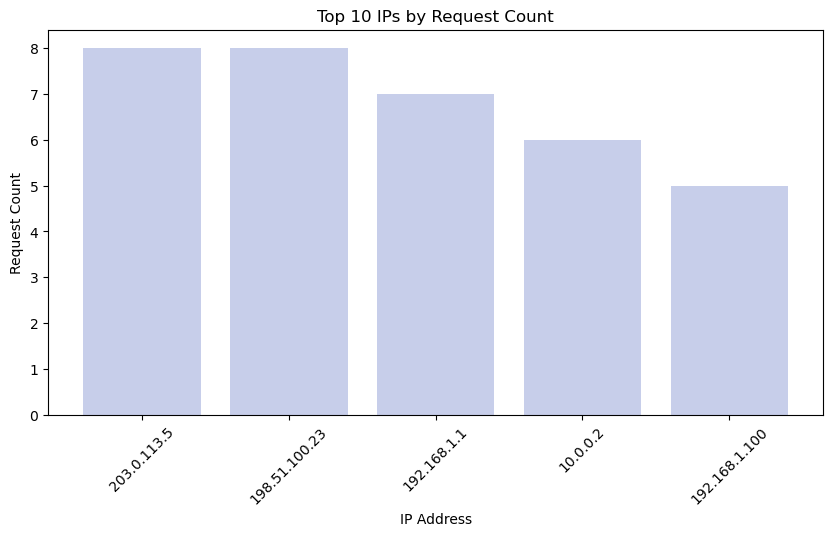

In [25]:
top_ips = sorted_ip_counts[:10]
ips, counts = zip(*top_ips)

plt.figure(figsize=(10, 5))
plt.bar(ips, counts, color='#C7CEEA')
plt.title("Top 10 IPs by Request Count")
plt.xlabel("IP Address")
plt.ylabel("Request Count")
plt.xticks(rotation=45)
plt.show()


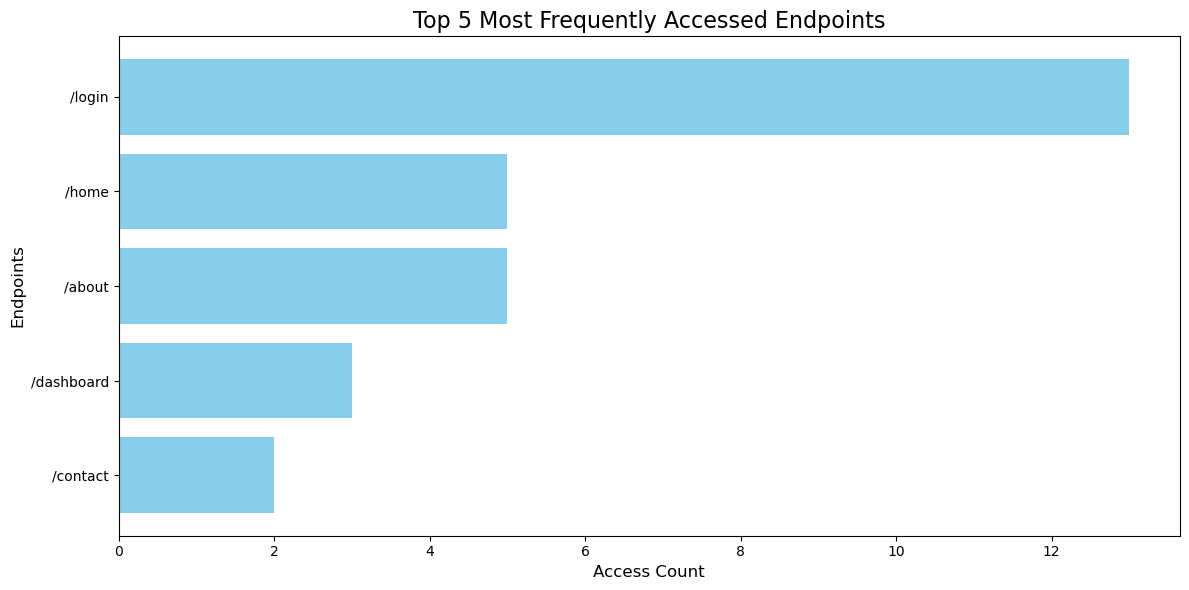

In [30]:
top_endpoints = endpoint_counter.most_common(5)
endpoints, counts = zip(*top_endpoints)

plt.figure(figsize=(12, 6))
plt.barh(endpoints, counts, color='skyblue')
plt.title("Top 5 Most Frequently Accessed Endpoints", fontsize=16)
plt.xlabel("Access Count", fontsize=12)
plt.ylabel("Endpoints", fontsize=12)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

### Final outputs stored in csv format :

In [31]:
output_file = "log_analysis_results.csv"

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(["Requests per IP"])
    writer.writerow(["IP Address", "Request Count"])
    for ip, count in sorted_ip_counts:
        writer.writerow([ip, count])
    
    writer.writerow([])
    writer.writerow(["Most Accessed Endpoint"])
    writer.writerow(["Endpoint", "Access Count"])
    writer.writerow([most_accessed_endpoint[0], most_accessed_endpoint[1]])
    
    writer.writerow([])
    writer.writerow(["Suspicious Activity"])
    writer.writerow(["IP Address", "Failed Login Count"])
    for ip, count in suspicious_ips.items():
        writer.writerow([ip, count])

print(f"Results saved to {output_file}")

Results saved to log_analysis_results.csv
